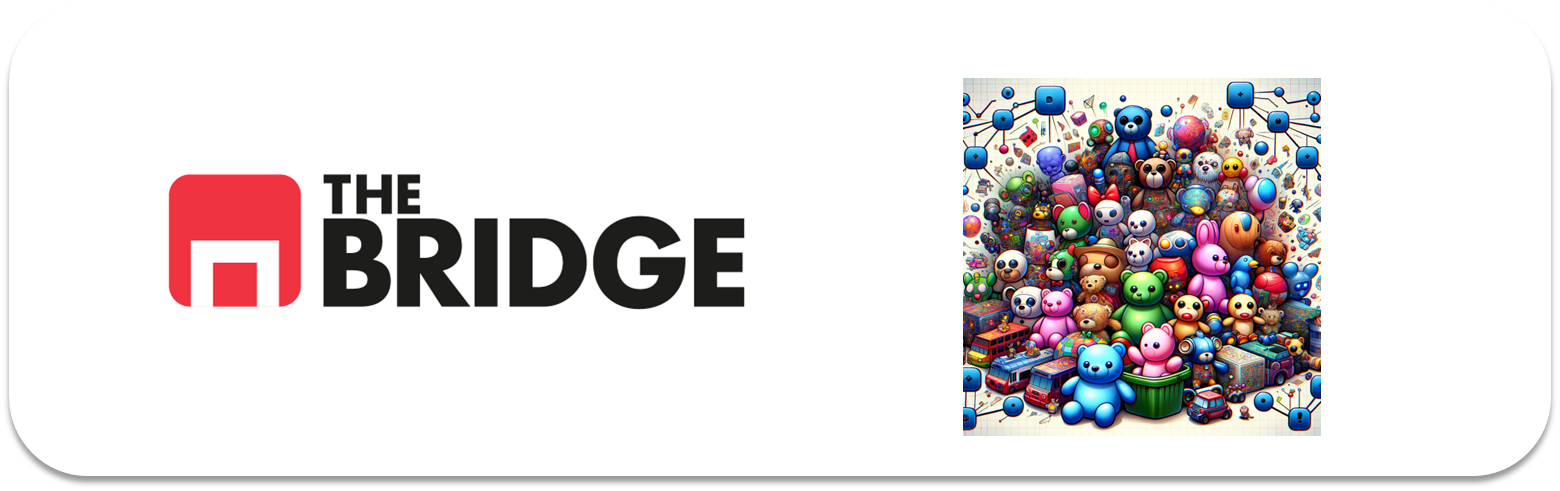

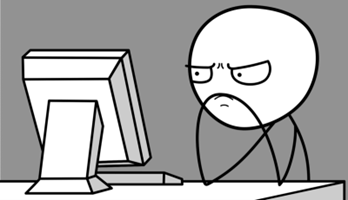

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [6]:
# Common imports
import numpy as np
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
import scipy.cluster.hierarchy as shc
from sklearn.cluster import AgglomerativeClustering
import funciones as fn
import seaborn as sns

# to make this notebook's output stable across runs
np.random.seed(5)

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")
warnings.filterwarnings("ignore", category=FutureWarning)

In [7]:
def plot_data(X):
    plt.plot(X[:, 0], X[:, 1], 'k.', markersize=2)

def plot_centroids(centroids, weights=None, circle_color='w', cross_color='b'):
    if weights is not None:
        centroids = centroids[weights > weights.max() / 10]
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='o', s=30, linewidths=8,
                color=circle_color, zorder=10, alpha=0.9)
    plt.scatter(centroids[:, 0], centroids[:, 1],
                marker='x', s=15, linewidths=20,
                color=cross_color, zorder=11, alpha=1)

def plot_decision_boundaries(clusterer, X, resolution=1000, show_centroids=True,
                             show_xlabels=True, show_ylabels=True):
    mins = X.min(axis=0) - 0.1
    maxs = X.max(axis=0) + 0.1
    xx, yy = np.meshgrid(np.linspace(mins[0], maxs[0], resolution),
                         np.linspace(mins[1], maxs[1], resolution))
    Z = clusterer.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    plt.contourf(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                cmap="Pastel2")
    plt.contour(Z, extent=(mins[0], maxs[0], mins[1], maxs[1]),
                linewidths=1, colors='k')
    plot_data(X)
    if show_centroids:
        plot_centroids(clusterer.cluster_centers_)

    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


In [8]:
df_all = pd.read_csv('./data/empowering_drinks.csv', sep = '|')
df_all.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,14.02,2.21,2.33,1035,4.70
1,11.56,3.23,5.08,465,6.00
2,12.58,2.10,0.58,640,7.60
3,12.33,2.28,1.09,680,3.27
4,12.37,1.36,0.57,520,1.95


In [9]:
df_all.shape

(157, 5)

In [10]:
fn.crea_df_std(df_all)

,name,type,prio,card,card%,NaN,Unknown,%_NaN,Category
0,Azúcares,float64,3,114,72.61,0,0,0.0,Numérica Continua
1,Vitamínas del grupo B,float64,3,74,47.13,0,0,0.0,Numérica Continua
2,Cafeína,float64,3,123,78.34,0,0,0.0,Numérica Continua
3,Ácido Cítrico,int64,3,112,71.34,0,0,0.0,Numérica Continua
4,Taurina,float64,3,120,76.43,0,0,0.0,Numérica Continua


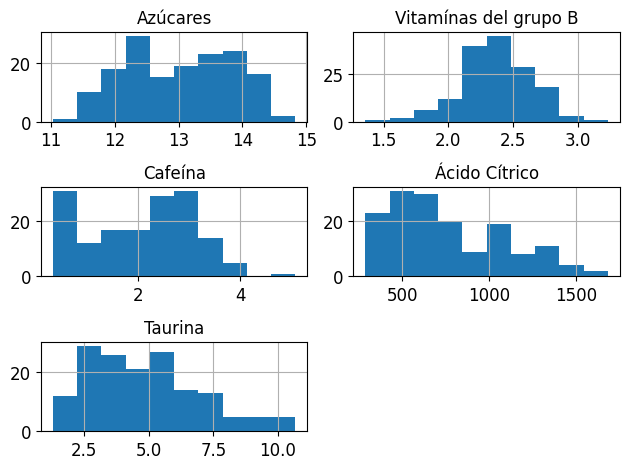

In [11]:
# No hay nulos, todas son numéricas. Vamos a hacer un estudio para ver cuales nos pueden servir.
df_all.hist()
plt.tight_layout()

In [12]:
df_all.describe()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,157.000000,157.000000,157.000000,157.000000,157.000000
mean,12.996815,2.368917,2.088790,763.089172,4.873694
std,0.845703,0.267394,1.027656,321.352179,2.151649
min,11.030000,1.360000,0.340000,290.000000,1.280000
25%,12.290000,2.220000,1.090000,502.000000,3.050000
50%,13.050000,2.360000,2.250000,680.000000,4.600000
75%,13.710000,2.560000,2.920000,1020.000000,6.100000
max,14.830000,3.230000,5.080000,1680.000000,10.680000


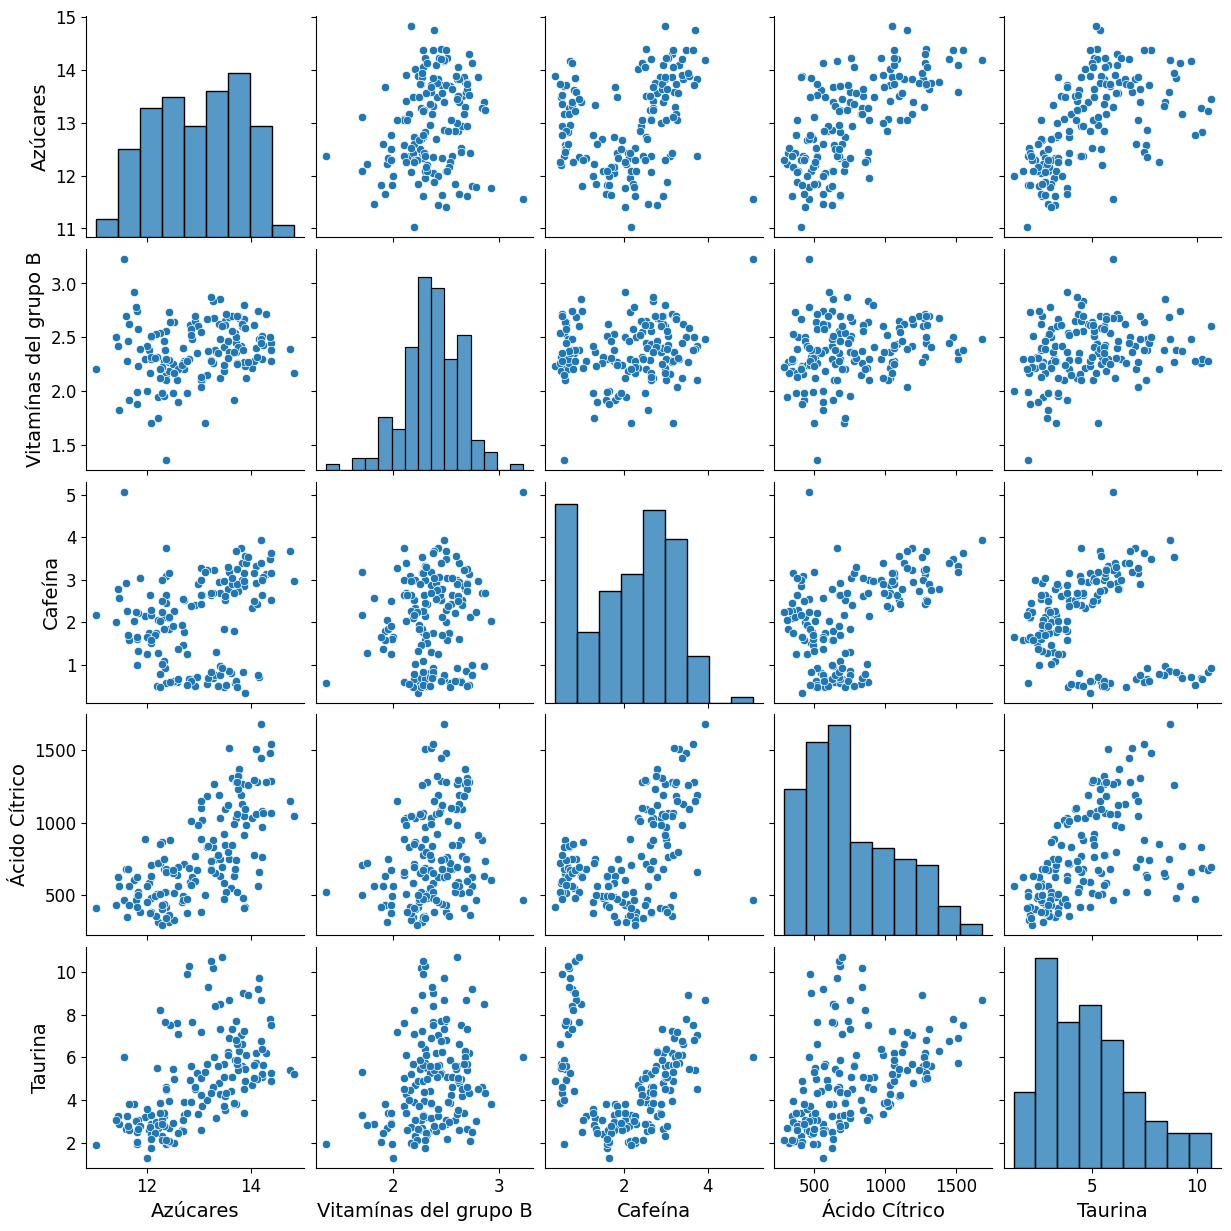

In [13]:
# En cuanto a la forma de la distribución de los datos vemos que podríamos intentar aplicar el logaritmo a Ácido cítrico y a taurina, tal vez también a Cafeína. Las otras dos tienen una distribución relativamente normal. 
# Vemos que cada valor tiene su escala así que necestiaríamos normalizarlos de alguna manera, un min_max escaler podría venir bien.
# Aunque primero vamos a ver la correlación entre cada una de las features.

sns.pairplot(df_all)

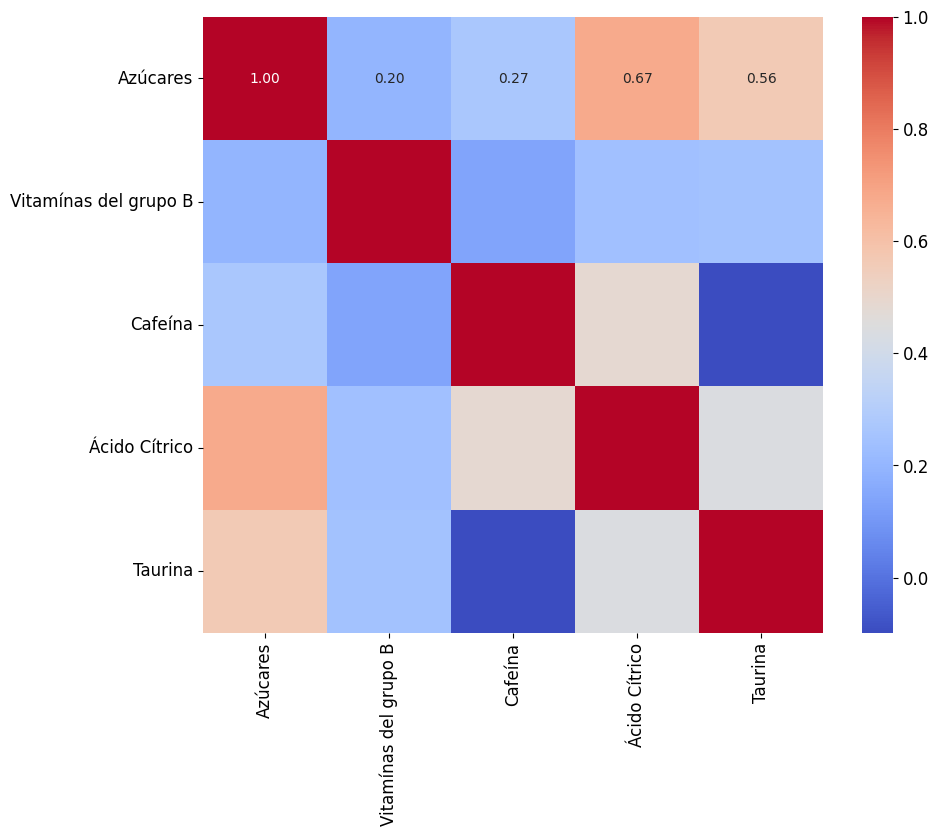

In [14]:
plt.figure(figsize=(10, 8))
sns.heatmap(df_all.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

# Como vemos no se aprecia ninguna correlación entre las columnas. Así que vamos a normalizarlas y a transformarlas.

In [15]:
df_save = df_all.copy()

array([[<Axes: title={'center': 'Azúcares'}>,
        <Axes: title={'center': 'Vitamínas del grupo B'}>],
       [<Axes: title={'center': 'Cafeína'}>,
        <Axes: title={'center': 'Ácido Cítrico'}>],
       [<Axes: title={'center': 'Taurina'}>, <Axes: >]], dtype=object)

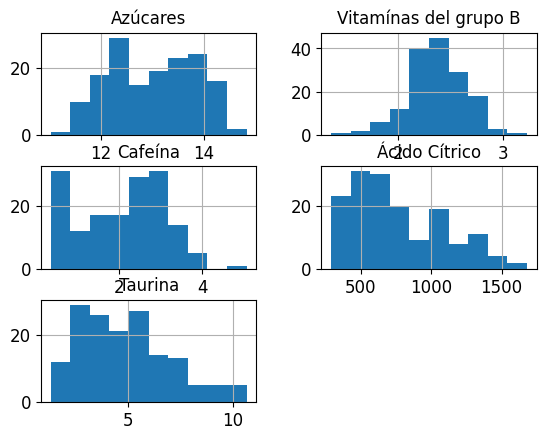

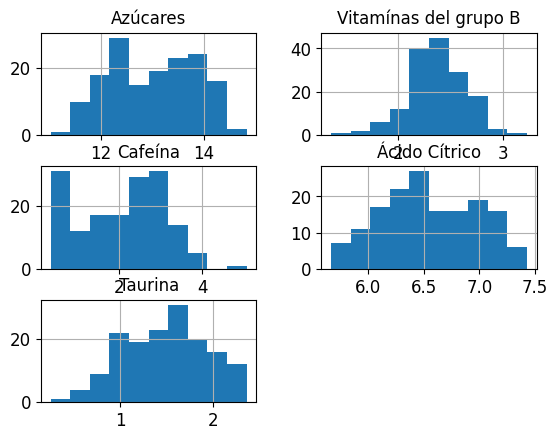

In [16]:
col_log = ['Ácido Cítrico', 'Taurina']

df_all.hist()

for col in col_log:
    df_save[col] = np.log(df_save[col])

df_save.hist()

# Le aplicamos la transformación log solo a estas dos columnas porque Cafeína se queda peor.

In [17]:
df_scaled = pd.DataFrame(StandardScaler().fit_transform(df_save), columns= df_save.columns, index = df_save.index)
df_scaled.describe()

# Ya tendríamos el df preparado. No prescindimos de ninguna feature porque parece que todas pueden aportar. 

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,1.570000e+02,1.570000e+02,1.570000e+02,1.570000e+02,1.570000e+02
mean,2.752222e-15,-4.101461e-16,-4.327748e-16,2.190746e-15,2.149731e-16
std,1.003200e+00,1.003200e+00,1.003200e+00,1.003200e+00,1.003200e+00
min,-2.333100e+00,-3.785225e+00,-1.707173e+00,-2.100353e+00,-2.757291e+00
25%,-8.384474e-01,-5.587030e-01,-9.750211e-01,-7.913819e-01,-8.250995e-01
50%,6.308944e-02,-3.345527e-02,1.573738e-01,-6.739922e-02,8.931104e-02
75%,8.460030e-01,7.168986e-01,8.114295e-01,8.998390e-01,7.173643e-01
max,2.174584e+00,3.230584e+00,2.920027e+00,2.090184e+00,1.963722e+00


In [31]:
X = df_scaled

dbscan = DBSCAN(eps=1.2, min_samples=5)

dbscan.fit(X)

DBSCAN(eps=1.2)

In [32]:
print(len(dbscan.labels_))      # Todos los datos etiquetados

# Los 10 primeros labels
print(dbscan.labels_[:10])

print(np.unique(dbscan.labels_, return_counts= True))        # Cuantos clusters ha montado

157
[ 0 -1  1  0 -1 -1  1  0  0 -1]
(array([-1,  0,  1], dtype=int64), array([ 11, 109,  37], dtype=int64))


In [33]:
# Cuantos core_sample_indices_
print(len(dbscan.core_sample_indices_))

# Los indices de los 10 primeros core_sample
print(dbscan.core_sample_indices_[:10])

# La posicion (coordenadas) de los 5 primeros core_sample
print(dbscan.components_[:5])

125
[ 0  2  3 10 11 12 13 15 17 18]
[[ 1.2137351  -0.59622069  0.23547     0.93466444  0.1371689 ]
 [-0.49443989 -1.00891533 -1.47288441 -0.21201943  1.20661872]
 [-0.79099805 -0.33359683 -0.97502112 -0.06739922 -0.67011059]
 [ 0.49013319 -0.93387994  0.57714088  0.93466444 -0.07114078]
 [ 1.37980766  0.41675707 -1.3557401  -0.13861355  1.74954337]]


In [23]:
dbscan2 = DBSCAN(eps=0.23, min_samples=5)
dbscan2.fit(X)

DBSCAN(eps=0.23)

In [24]:
print(len(dbscan2.labels_))      # Todos los datos etiquetados
# Los 10 primeros labels
print(dbscan2.labels_[:10])
print(np.unique(dbscan2.labels_, return_counts= True))        # Cuantos clusters ha montado
# Cuantos core_sample_indices_
print(len(dbscan2.core_sample_indices_))
# Los indices de los 10 primeros core_sample
print(dbscan2.core_sample_indices_[:10])
# La posicion (coordenadas) de los 5 primeros core_sample
print(dbscan2.components_[:5])

157
[-1 -1 -1 -1 -1 -1 -1 -1 -1 -1]
(array([-1], dtype=int64), array([157], dtype=int64))
0
[]
[]


In [119]:
def plot_dbscan(dbscan, X, size, show_xlabels=True, show_ylabels=True):
    # Convertir X a un array de NumPy si es un DataFrame de Pandas
    if isinstance(X, pd.DataFrame):
        X = X.values
    
    core_mask = np.zeros_like(dbscan.labels_, dtype=bool)
    core_mask[dbscan.core_sample_indices_] = True
    anomalies_mask = dbscan.labels_ == -1
    non_core_mask = ~(core_mask | anomalies_mask)

    cores = dbscan.components_
    anomalies = X[anomalies_mask]
    non_cores = X[non_core_mask]
    
    plt.scatter(cores[:, 0], cores[:, 1],
                c=dbscan.labels_[core_mask], marker='o', s=size, cmap="Paired")
    plt.scatter(cores[:, 0], cores[:, 1], marker='*', s=20, c=dbscan.labels_[core_mask])
    plt.scatter(anomalies[:, 0], anomalies[:, 1],
                c="r", marker="x", s=100)
    plt.scatter(non_cores[:, 0], non_cores[:, 1], c=dbscan.labels_[non_core_mask], marker=".")
    if show_xlabels:
        plt.xlabel("$x_1$", fontsize=14)
    else:
        plt.tick_params(labelbottom=False)
    if show_ylabels:
        plt.ylabel("$x_2$", fontsize=14, rotation=0)
    else:
        plt.tick_params(labelleft=False)
    plt.title("eps={:.2f}, min_samples={}".format(dbscan.eps, dbscan.min_samples), fontsize=14)

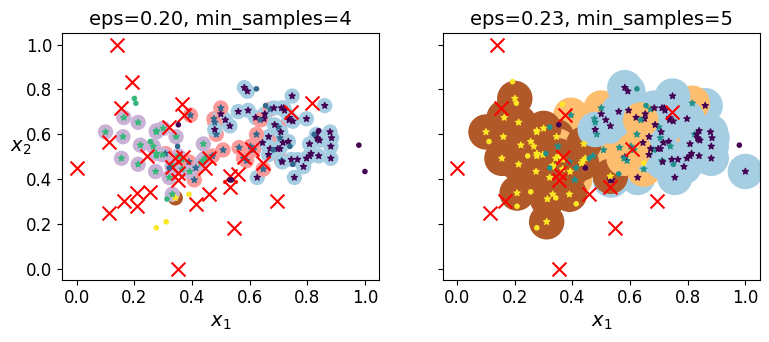

In [172]:
plt.figure(figsize=(9, 3.2))

plt.subplot(121)
plot_dbscan(dbscan, X, size=100)

plt.subplot(122)
plot_dbscan(dbscan2, X, size=600, show_ylabels=False)


plt.show()

In [ ]:
# A mi modo de ver, diría que DBscan2 es mejor, con eps = 0.23 y min_samples = 5.
# Tiene menos ourlayers. Los clusters parecen que están equilibrados y relativamente diferenciados. 

In [202]:
# Vamos ahora a probar con un modelo jeráquico. Cargamos esta función para pintar los dendrogramas.
def pinta_dendrograma(data, method = 'ward', metric = 'euclidean', line = False):
    plt.figure(figsize=(10, 7))
    plt.title("Customers Dendogram with line")
    clusters = shc.linkage(data, 
                method= method, 
                metric= metric)
    shc.dendrogram(clusters)
    if line != False:
        plt.axhline(y = line, color = 'r', linestyle = '-') 

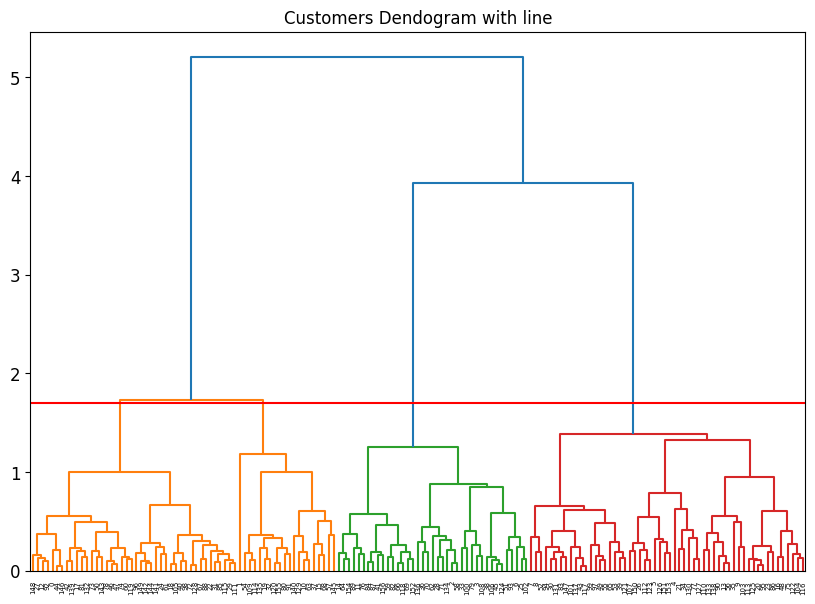

In [204]:
pinta_dendrograma(X, line = 1.7)

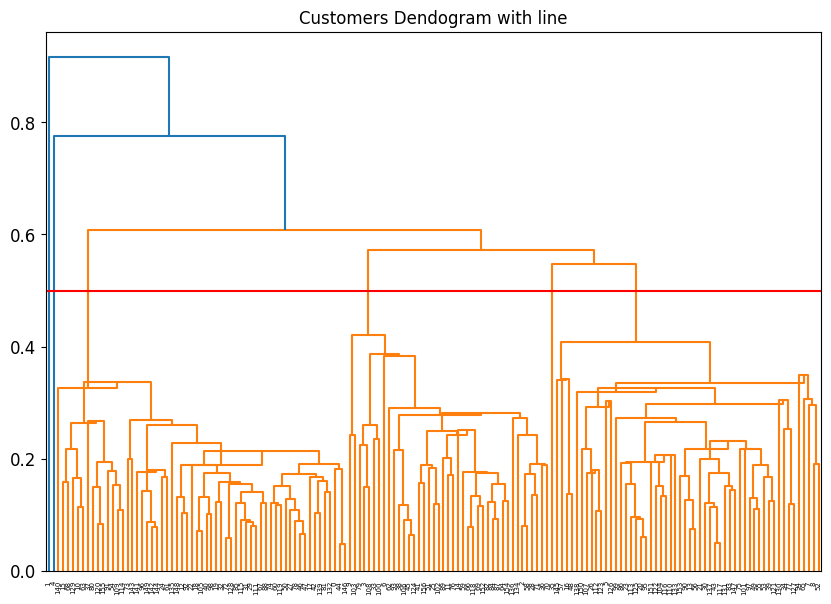

In [211]:
pinta_dendrograma(X, method= 'centroid', line = 0.5)

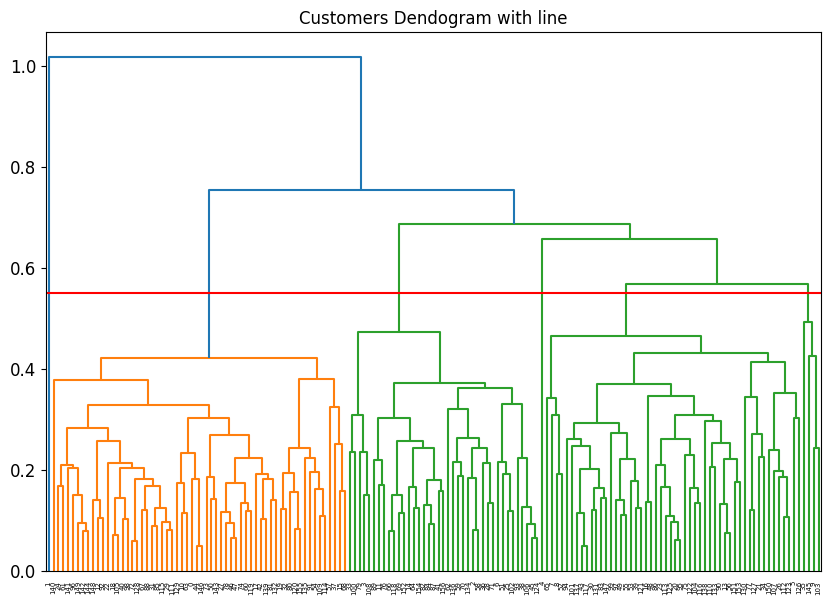

In [214]:
pinta_dendrograma(X, method= 'average', line = 0.55)

In [208]:
clustering_model = AgglomerativeClustering(n_clusters=4, metric='euclidean', linkage='ward')
clustering_model.fit(X)
clustering_model.labels_

array([3, 1, 2, 2, 0, 0, 2, 0, 0, 0, 1, 2, 3, 0, 2, 1, 0, 3, 3, 1, 0, 0,
       3, 0, 3, 2, 0, 3, 2, 3, 0, 3, 1, 2, 0, 0, 2, 1, 2, 0, 3, 2, 3, 0,
       3, 2, 3, 3, 0, 0, 3, 2, 0, 0, 1, 0, 0, 1, 2, 2, 3, 3, 2, 1, 2, 0,
       2, 3, 1, 2, 2, 2, 3, 3, 3, 0, 2, 0, 3, 2, 1, 3, 2, 0, 2, 3, 0, 2,
       3, 2, 0, 1, 3, 2, 0, 0, 3, 0, 3, 0, 2, 0, 2, 0, 0, 3, 2, 0, 2, 1,
       0, 3, 0, 0, 1, 3, 0, 0, 2, 3, 1, 0, 0, 0, 2, 0, 0, 0, 3, 1, 0, 0,
       3, 0, 2, 1, 2, 0, 0, 3, 1, 3, 3, 3, 3, 1, 3, 0, 3, 3, 0, 0, 2, 0,
       2, 1, 2], dtype=int64)

In [210]:
# En este caso me quedaría con esta agrupación ya que creo que aporta más divisiones, y son clusters diferenciados.

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [183]:
new_data = pd.read_csv('./data/new_experiments.csv', sep = '|')     # Cargamos lo datos y le aplicamos el mismo proceso.
for col in col_log:                                                 # Aplicamos el log
    new_data[col] = np.log(new_data[col])
new_scaled = pd.DataFrame(MinMaxScaler().fit_transform(new_data), columns= new_data.columns, index = new_data.index)    # Escalamos
X_new = new_scaled.values       # Lo pasamos a un Array de np para para hacer el predict

In [185]:
knn = KNeighborsClassifier(n_neighbors=10)
knn.fit(dbscan2.components_, dbscan2.labels_[dbscan2.core_sample_indices_])     # Entrenamos con las core del DBscan

KNeighborsClassifier(n_neighbors=10)

In [193]:
knn2 = KNeighborsClassifier(n_neighbors=10)
knn2.fit(X.values, dbscan2.labels_)     # Entrenamos con todas, incluidas anomalías

KNeighborsClassifier(n_neighbors=10)

In [186]:
knn.predict(X_new)      # Esta sería la clasificación. 

array([0, 0, 2, 0, 1, 1], dtype=int64)

In [187]:
knn.predict_proba(X_new)

array([[1. , 0. , 0. ],
       [1. , 0. , 0. ],
       [0. , 0. , 1. ],
       [0.7, 0. , 0.3],
       [0. , 1. , 0. ],
       [0. , 1. , 0. ]])

In [194]:
knn2.predict(X_new)      # Esta sería la clasificación para knn2. El caso es que varía en uno de los casos.

array([0, 0, 2, 2, 1, 1], dtype=int64)

### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.